#** Actor Critic Iplementation**

## install packages

In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


## import packages

In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

# Install Packages

In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

**Actor-Critic methods** learn both a policy $\pi(a|s;\theta)$ and a state-value function $v(s;w)$ simultaneously. The policy is referred to as the actor that suggests actions given a state. The estimated value function is referred to as the critic. It evaluates actions taken by the actor based on the given policy. In this exercise, both functions are approximated by feedforward neural networks. 

- The policy network is parametrized by $\theta$ - it takes a state $s$ as input and outputs the probabilities $\pi(a|s;\theta)\ \forall\ a$
- The value network is parametrized by $w$ - it takes a state $s$ as input and outputs a scalar value associated with the state, i.e., $v(s;w)$
- The single step TD error can be defined as follows:
$$\delta_t  = R_{t+1} + \gamma v(s_{t+1};w) - v(s_t;w)$$
- The loss function to be minimized at every step ($L_{tot}^{(t)}$) is a summation of two terms, as follows:
$$L_{tot}^{(t)} = L_{actor}^{(t)} + L_{critic}^{(t)}$$
where,
$$L_{actor}^{(t)} = -\log\pi(a_t|s_t; \theta)\delta_t$$
$$L_{critic}^{(t)} = \delta_t^2$$
- **NOTE: Here, weights of the first two hidden layers are shared by the policy and the value network**
    - First two hidden layer sizes: [1024, 512]
    - Output size of policy network: 2 (Softmax activation)
    - Output size of value network: 1 (Linear activation)

<!-- $$\pi(a|s;\theta) = \phi_{\theta}(a,s)$$ -->

### Initializing Actor-Critic Network

In [ ]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=1024, n_hidden2=512):
        super(ActorCriticModel, self).__init__()

        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)

        pi = self.pi_out(layer2)
        v = self.v_out(layer2)

        return pi, v

### Agent Class



In [ ]:
class Agent:
    """
    Agent class
    """
    def __init__(self, action_size, lr=0.001, gamma=0.90, seed = 85):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        np.random.seed(seed)
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0,action]) * delta

    def critic_loss(self,delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    @tf.function
    def learn(self, state, action, reward, next_state, done):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            _, V_s_next = self.ac_model(next_state)

            V_s = tf.squeeze(V_s)
            V_s_next = tf.squeeze(V_s_next)
            

            delta = reward + self.gamma * V_s_next - V_s 
            loss_a = self.actor_loss(action, pi, delta) # actor loss
            loss_c =self.critic_loss(delta) # critic loss
            loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

    

    

### 1 step reward

In [ ]:

average_reward_list = np.zeros((10, 1000))
begin_time = datetime.datetime.now()

for i in range(10):
    env = gym.make('CartPole-v1')


    #Initializing Agent
    agent = Agent(lr=1e-4, action_size=env.action_space.n, gamma = .99)
    #Number of episodes
    episodes = 1000
    tf.compat.v1.reset_default_graph()
    reward_list = []
    for ep in range(1, episodes + 1):
        state = env.reset().reshape(1,-1)
        
        done = False
        ep_rew = 0
        while not done:
            action = agent.sample_action(state) ##Sample Action
            next_state, reward, done, info = env.step(action) ##Take action
            next_state = next_state.reshape(1,-1)
            ep_rew += reward  ##Updating episode reward
            agent.learn(state, action, reward, next_state, done) ##Update Parameters
            state = next_state ##Updating State
        reward_list.append(ep_rew)
        average_reward_list[i][ep-1] = ep_rew


        if ep % 10 == 0:
            avg_rew = np.mean(reward_list[-10:])
            print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)
        

        if ep % 100:
            avg_100 =  np.mean(reward_list[-100:])
            if avg_100 > 195.0:
                print('Stopped at Episode ',ep-100)
    


time_taken = datetime.datetime.now() - begin_time
print(time_taken)

### n steps actor critic


In [ ]:
# n step reward
n = 3
env = gym.make('CartPole-v1')


#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n)
#Number of episodes
episodes = 1800
tf.compat.v1.reset_default_graph()

reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    ## using the three lists to store the experience
    states =[state] # contains states s1, s2, s3 ........
    actions = [] # contains actions a1, a2, a3 .........
    rewards = [] # contains rewards r1, r2, r3 .........

    T=0

    while not done:

        T += 1

        # sample action
        action = agent.sample_action(state) 
        actions.append(action)  # add action in memory

        # take the action
        next_state, reward, done, info = env.step(action)
        next_state = next_state.reshape(1,-1)

        states.append(next_state)
        rewards.append(reward)

        ep_rew += reward  ##Updating episode reward
        
        state = next_state ##Updating State
    reward_list.append(ep_rew)

    # calculate the discounted return over n steps
    for t in range(T-1, -1, -1):
        n_step_reward = 0

        for i in range(n-1, -1, -1):
            if i+t < T:
                n_step_reward = rewards[t+i] + agent.gamma * n_step_reward

        # call the agent to learn
        agent.learn(states[t], actions[t], n_step_reward, states[min(T, t+n)], done)
                  # S            A         R= n step return              S'

    if ep % 10 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > 195.0:
            print('Stopped at Episode ',ep-100)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward 12.000000 Average Reward 28.600000
Episode  20 Reward 15.000000 Average Reward 18.900000
Episode  30 Reward 13.000000 Average Reward 14.100000
Episode  40 Reward 12.000000 Average Reward 18.700000
Episode  50 Reward 22.000000 Average Reward 15.900000
Episode  60 Reward 17.000000 Average Reward 20.900000
Episode  70 Reward 22.000000 Average Reward 17.700000
Episode  80 Reward 12.000000 Average Reward 16.000000
Episode  90 Reward 15.000000 Average Reward 14.000000
Episode  100 Reward 16.000000 Average Reward 22.400000
Episode  110 Reward 10.000000 Average Reward 11.900000
Episode  120 Reward 12.000000 Average Reward 14.800000
Episode  130 Reward 12.000000 Average Reward 14.800000
Episode  140 Reward 52.000000 Average Reward 20.200000
Episode  150 Reward 20.000000 Average Reward 22.600000
Episode  160 Reward 12.000000 Average Reward 18.200000
Episode  170 Reward 21.000000 Average Reward 18.400000
Episode  180 Reward 21.000000 Average Reward 18.600000
Episode  190 Reward

KeyboardInterrupt: ignored

### full episode rewards

In [ ]:
from tensorflow.keras.losses import MSE

In [ ]:
# full episode rewards
env = gym.make('CartPole-v1')


#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n, gamma = 0.99)
#Number of episodes
episodes = 1800
tf.compat.v1.reset_default_graph()

reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()

for ep in range(1, episodes + 1):
    with tf.GradientTape() as tape:
        state = env.reset().reshape(1,-1)

        values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

        action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True) # a1, a2, a3 ............
        done = False
        ep_rew = 0
        final_state = state
        t = 0
        while not done:
            t += 1
            # Run the model and to get action probabilities and critic value
            action_probs_t, value = agent.ac_model(state)

            action = agent.sample_action(state) ##Sample Action
            
            # Store log probability of the action chosen
            action_probs = action_probs.write(t, action_probs_t[0, action])

            # Store critic values
            values = values.write(t, tf.squeeze(value))

            next_state, reward, done, info = env.step(action) ##Take action

            next_state = next_state.reshape(1,-1)
            
            # Store reward
            rewards = rewards.write(t, int(reward))
            final_state = next_state

            ep_rew += reward  ##Updating episode reward

            state = next_state ##Updating State
        reward_list.append(ep_rew)

        action_probs = action_probs.stack()
        values = values.stack()
        rewards = rewards.stack()

    
        """Compute expected returns per timestep."""

        n = tf.shape(rewards)[0]
        returns = tf.TensorArray(dtype=tf.float32, size=n)

        # Start from the end of `rewards` and accumulate reward sums
        # into the `returns` array
        rewards = tf.cast(rewards[::-1], dtype=tf.float32)
        discounted_sum = tf.constant(0.0)
        discounted_sum_shape = discounted_sum.shape

        for i in tf.range(n):
          reward = rewards[i]
          discounted_sum = reward + agent.gamma * discounted_sum
          discounted_sum.set_shape(discounted_sum_shape)
          returns = returns.write(i, discounted_sum)
        returns = returns.stack()[::-1]
    
    
        """Computes the combined Actor-Critic loss."""

        advantage = returns - values

        action_log_probs = tf.math.log(action_probs)
        actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

        critic_loss = MSE(values, returns)
    
        loss_total = actor_loss + critic_loss

    # update the parameters
    gradient = tape.gradient(loss_total, agent.ac_model.trainable_variables)
    agent.ac_model.optimizer.apply_gradients(zip(gradient, agent.ac_model.trainable_variables))

    if ep % 10 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > 195.0:
            print('Stopped at Episode ',ep-100)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

NameError: ignored

### **Task 2b**: Plot total reward curve
In the cell below, write code to plot the total reward averaged over 100 episodes (moving average)

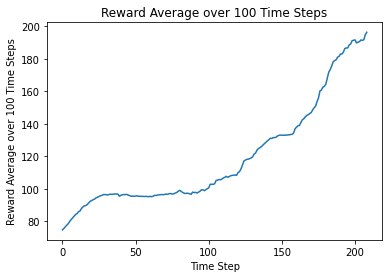

In [ ]:
### Plot of total reward vs episode
## Write Code Below
import numpy as np
rolling_avg = np.convolve(reward_list, np.ones(100)/100, mode='valid')
    
# Plot the rolling average over time steps
plt.plot(rolling_avg)
plt.xlabel('Time Step')
plt.ylabel('Reward Average over ' + str(100) + ' Time Steps')
plt.title('Reward Average over ' + str(100) + ' Time Steps')
plt.show()



### Code for rendering ([source](https://colab.research.google.com/drive/1D6bvoEVukil7DUaJU465vtfuDgLDbOY7#scrollTo=qbIMMkfmRHyC))

In [ ]:
# Render an episode and save as a GIF file

display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))
    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, agent.ac_model, 200)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

AttributeError: ignored


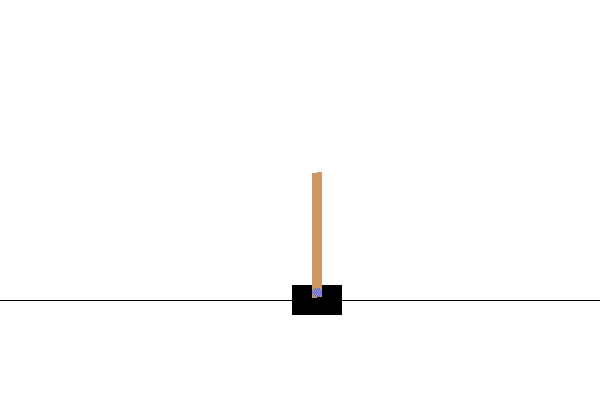

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

In [ ]:
!pip install nbconvert
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 javascript-common libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn11 libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6
  libpdfbox-java libptexenc1 libruby2.7 libsynctex2 libteckit0 libtexlua53
  libtexluajit2 libzzip-0-13 lmodern poppler-data preview-latex-style rake
  ruby ruby-minitest ruby-net-telnet ruby-power-assert ruby-test-unit
  ruby-xmlrpc ruby2.7 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested p

In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Tutorial_5_DQN_and_AC.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Tutorial_5_DQN_and_AC.ipynb to html
[NbConvertApp] Writing 868263 bytes to /content/drive/MyDrive/Colab Notebooks/Tutorial_5_DQN_and_AC.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
